<a href="https://colab.research.google.com/github/laribar/TechChallenge2/blob/main/TechChallenge2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime




In [105]:
# URL do arquivo bruto
url = 'https://raw.githubusercontent.com/laribar/TechChallenge2/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv'

# Leia o CSV usando pandas, especificando decimal e thousands, e parse_dates para converter a data corretamente
df = pd.read_csv(url, decimal=',', thousands='.', parse_dates=['Data'], dayfirst=True)

# Exibir as primeiras linhas do DataFrame
print(df.head())

        Data  Último  Abertura  Máxima  Mínima    Vol.    Var%
0 2025-01-31  126222    126914  127532  126187   8,11M  -0,54%
1 2025-01-30  126913    123433  127169  123432  11,69B   2,82%
2 2025-01-29  123432    124056  124767  123278   7,35B  -0,50%
3 2025-01-28  124056    124861  124881  123973   8,31B  -0,65%
4 2025-01-27  124862    122443  124862  122207  11,02B   1,97%


In [106]:
# Renomear a coluna 'último' para 'fechamento'
df.rename(columns={'Último': 'Fechamento'}, inplace=True)

# Visualizar as primeiras linhas após renomear as colunas
print("\nColunas após a renomeação:")
print(df.columns)

# Exibir as primeiras linhas do DataFrame para confirmar a alteração
print(df.head())


Colunas após a renomeação:
Index(['Data', 'Fechamento', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%'], dtype='object')
        Data  Fechamento  Abertura  Máxima  Mínima    Vol.    Var%
0 2025-01-31      126222    126914  127532  126187   8,11M  -0,54%
1 2025-01-30      126913    123433  127169  123432  11,69B   2,82%
2 2025-01-29      123432    124056  124767  123278   7,35B  -0,50%
3 2025-01-28      124056    124861  124881  123973   8,31B  -0,65%
4 2025-01-27      124862    122443  124862  122207  11,02B   1,97%


In [107]:
# Supondo que você já tenha carregado os dados e renomeado a coluna conforme necessário

# Converter a coluna 'Data' para o tipo datetime, caso ainda não esteja
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')

# Verifique se houve alguma falha ao converter
if df['Data'].isnull().any():
    print("Atenção: Existem valores em 'Data' que não puderam ser convertidos. Verifique suas entradas de dados.")

# Definir 'Data' como índice
df.set_index('Data', inplace=True)

# Verifique as primeiras linhas para confirmar a mudança
print(df.head())

            Fechamento  Abertura  Máxima  Mínima    Vol.    Var%
Data                                                            
2025-01-31      126222    126914  127532  126187   8,11M  -0,54%
2025-01-30      126913    123433  127169  123432  11,69B   2,82%
2025-01-29      123432    124056  124767  123278   7,35B  -0,50%
2025-01-28      124056    124861  124881  123973   8,31B  -0,65%
2025-01-27      124862    122443  124862  122207  11,02B   1,97%


In [108]:
# Resumo estatístico dos dados
print(df.describe())

          Fechamento       Abertura         Máxima         Mínima
count    1267.000000    1267.000000    1267.000000    1267.000000
mean   113692.657459  113684.749803  114686.966851  112687.832676
std     12710.336538   12705.353837   12432.272117   12956.685395
min     63570.000000   63604.000000   67604.000000   61691.000000
25%    106141.000000  106133.000000  107109.500000  105047.500000
50%    114979.000000  114977.000000  115729.000000  113635.000000
75%    122951.000000  122918.000000  123772.500000  122098.500000
max    137344.000000  137349.000000  137469.000000  136664.000000


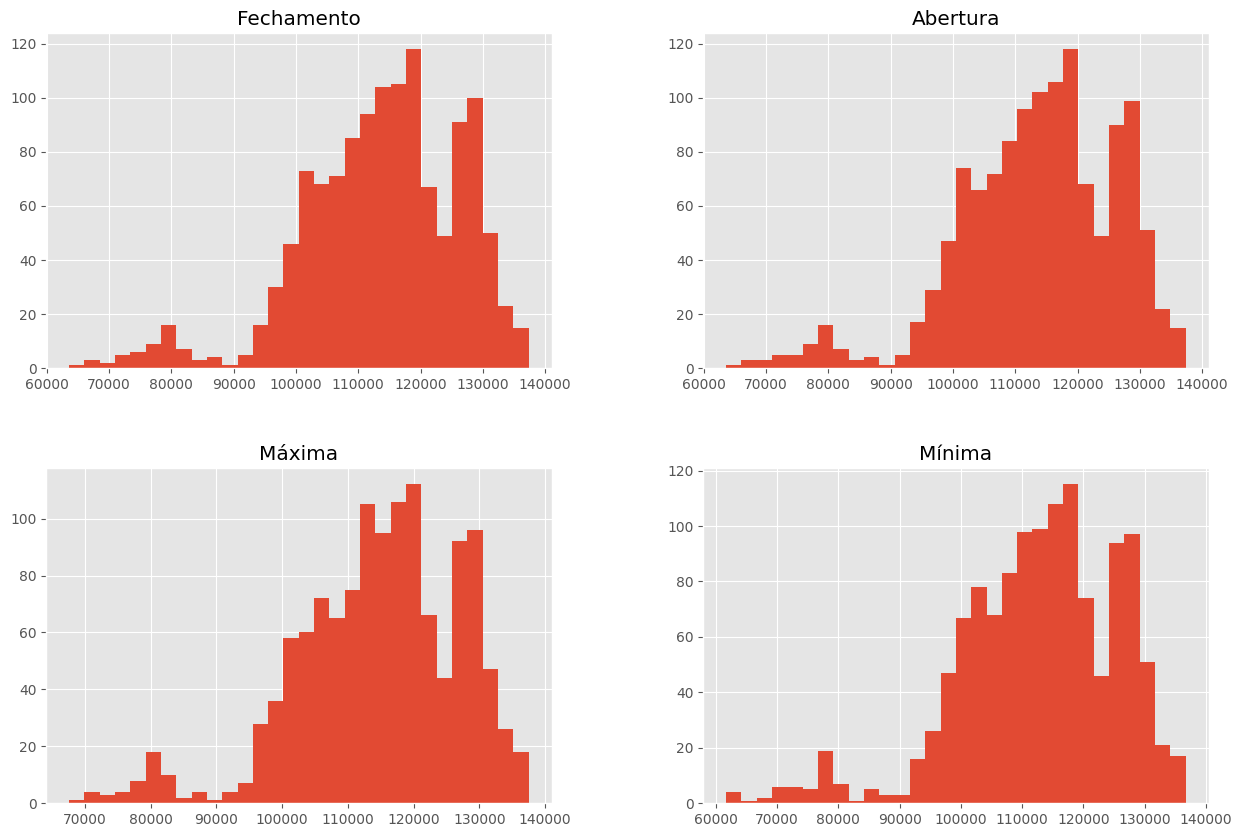

In [109]:
df.hist(bins=30, figsize=(15, 10))
plt.show()

In [110]:

# Defina uma função para converter os valores da coluna 'Vol.' em um formato numérico válido
def convert_to_float(value):
    try:
        if 'M' in value:
            return float(value.replace('M', '').replace(',', '.')) * 1e6
        elif 'K' in value:
            return float(value.replace('K', '').replace(',', '.')) * 1e3
        else:
            return float(value.replace(',', '.'))
    except ValueError:
        return None  # ou algum valor padrão caso de erro

# Aplicando a função de conversão à coluna 'Vol.'
df['Vol.'] = df['Vol.'].map(convert_to_float)

# Verificar as primeiras linhas para confirmar a transformação
print(df[['Vol.']].head())

                 Vol.
Data                 
2025-01-31  8110000.0
2025-01-30        NaN
2025-01-29        NaN
2025-01-28        NaN
2025-01-27        NaN


In [74]:
# Mostra exemplos de valores que não puderam ser convertidos
problemas = df[df['Vol.'].isna()]['Vol.']
print(problemas.head(10))  # Exibir alguns valores problemáticos

Data
2025-01-30   NaN
2025-01-29   NaN
2025-01-28   NaN
2025-01-27   NaN
2025-01-24   NaN
2025-01-23   NaN
2025-01-22   NaN
2025-01-21   NaN
2025-01-20   NaN
2025-01-17   NaN
Name: Vol., dtype: float64


In [111]:
def convert_to_float(value):
    try:
        # Remover possíveis whitespaces e trocar vírgula por ponto
        clean_value = str(value).strip().replace('.', '').replace(',', '.')

        # Funcionar para milhões e milhares
        if 'M' in clean_value:
            return float(clean_value.replace('M', '')) * 1e6
        elif 'K' in clean_value:
            return float(clean_value.replace('K', '')) * 1e3
        elif '%' in clean_value:
            return float(clean_value.replace('%', '')) / 100
        else:
            return float(clean_value)
    except Exception as e:
        print(f"Erro ao converter valor '{value}': {e}")
        return None

# Re-aplicar limpeza da coluna
df['Vol.'] = df['Vol.'].map(lambda x: convert_to_float(x) if isinstance(x, str) else x)
# Substituir NaN por um valor padrão, por exemplo 0, ou usar técnica estatística
df['Vol.'].fillna(0, inplace=True)  #_substituir por média, mediana se fizer sentido para a análise
# Mostrar as primeiras linhas após tentativa de nova conversão
print(df[['Vol.']].head())


                 Vol.
Data                 
2025-01-31  8110000.0
2025-01-30        0.0
2025-01-29        0.0
2025-01-28        0.0
2025-01-27        0.0


<ipython-input-111-8171d9cd6bb1>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Vol.'].fillna(0, inplace=True)  #_substituir por média, mediana se fizer sentido para a análise


In [112]:
def percent_to_float(percent_str):
    try:
        return float(percent_str.replace(',', '.').replace('%', '')) / 100
    except ValueError:
        return None

# Suponha que a coluna 'Var%' contenha valores percentuais
df['Var%'] = df['Var%'].map(lambda x: percent_to_float(x) if isinstance(x, str) else x)

# Verifique as primeiras linhas para certificar-se da conversão adequada
print(df[['Var%']].head())

              Var%
Data              
2025-01-31 -0.0054
2025-01-30  0.0282
2025-01-29 -0.0050
2025-01-28 -0.0065
2025-01-27  0.0197


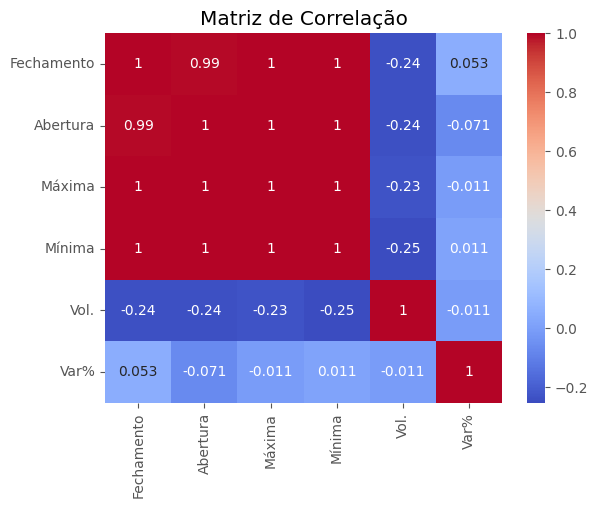

In [77]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

In [113]:
# Preencher ou remover valores ausentes
df.fillna(method='ffill', inplace=True)

<ipython-input-113-b3ecaff05721>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [114]:
# Confira a lista de colunas ou visualize o índice do DataFrame
print("Colunas do DataFrame:")
print(df.columns.tolist())

print("\nNome do Índice:")
print(df.index.name)

Colunas do DataFrame:
['Fechamento', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']

Nome do Índice:
Data


In [115]:
# Exemplo acessando valores diretamente baseados no índice
print(df.loc['2025-01-30'])  # Supondo um acesso específico

Fechamento    126913.0000
Abertura      123433.0000
Máxima        127169.0000
Mínima        123432.0000
Vol.               0.0000
Var%               0.0282
Name: 2025-01-30 00:00:00, dtype: float64


In [116]:
# Variável alvo (dependente)
y = df['Fechamento']

# Variáveis preditoras (independentes) - adaptável conforme análise aprofundada
X = df.drop(columns=['Fechamento', 'Var%'])  # Exclua colunas desnecessárias como 'Var%', por exemplo

# Dividir o conjunto de dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar conjuntos
print("Conjuntos de treino:", X_train.shape, y_train.shape)
print("Conjuntos de teste:", X_test.shape, y_test.shape)

Conjuntos de treino: (1013, 4) (1013,)
Conjuntos de teste: (254, 4) (254,)


In [117]:
# Criar instância do modelo de Regressão Linear
model = LinearRegression()

# Treinar o modelo
model.fit(X_train, y_train)

LinearRegression()

In [118]:
# Ordenar os dados se necessário - geralmente por data é essencial para séries temporais
df.sort_index(inplace=True)

# Verificar o dataset
print(df.head())

            Fechamento  Abertura  Máxima  Mínima       Vol.    Var%
Data                                                               
2020-01-02      118573    115652  118573  115649  5160000.0  0.0253
2020-01-03      117707    118564  118792  117341  6830000.0 -0.0073
2020-01-06      116878    117707  117707  116269  6570000.0 -0.0070
2020-01-07      116662    116872  117076  115965  4850000.0 -0.0018
2020-01-08      116247    116667  117335  115693  5910000.0 -0.0036


In [119]:
# Assegure-se de que a coluna 'Data' está no tipo datetime e é o índice
df.index = pd.to_datetime(df.index)

# Dividir o dataset em treino até 2025-01-25 e teste dos últimos 5 dias
cutoff_date = '2025-01-25'
train = df.loc[:cutoff_date].copy()
test = df.loc[cutoff_date:].copy()

print("Período de treino até:", train.index.max())
print("Período de testes a partir de:", test.index.min())

Período de treino até: 2025-01-24 00:00:00
Período de testes a partir de: 2025-01-27 00:00:00


In [120]:

# Use deslocamentos (lags) nos dados pode ser uma técnica adicional mesmo em modelos que não sejam tradicionais para séries da regressão.
train['Lag1'] = train['Fechamento'].shift(1)

# Remover valores nulos iniciais
train.dropna(inplace=True)

# Aplicar o modelo para ajuste no conjunto de treino
X_train = train[['Lag1']]  # Exemplo simples de uma variável de atraso
y_train = train['Fechamento']

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [121]:
# Corrigir coluna Lag1 no conjunto de teste para dados semelhantes a treino
test['Lag1'] = test['Fechamento'].shift(1)

# Atualizar dados removendo NaN provenientes de deslocamento
X_test = test[['Lag1']].dropna()
y_test = test.loc[X_test.index, 'Fechamento']  # Garantir mesmo índice de X_test

In [122]:
# Assegure-se de que a coluna 'Data' está no tipo datetime e é o índice
df.index = pd.to_datetime(df.index)

# Dividir o dataset em treino até 2025-01-25 e teste dos últimos 5 dias
cutoff_date = '2025-01-25'
train = df.loc[:cutoff_date].copy()
test = df.loc[cutoff_date:].copy()

print("Período de treino até:", train.index.max())
print("Período de testes a partir de:", test.index.min())

Período de treino até: 2025-01-24 00:00:00
Período de testes a partir de: 2025-01-27 00:00:00


In [123]:
# Use deslocamento para seuo ámbito de treinamento
train['Lag1'] = train['Fechamento'].shift(1)
train.dropna(inplace=True)  # Remova quaisquer `NaN` que resultam do deslocamento

In [124]:
# Defina as variáveis preditoras e alvo
X_train = train[['Lag1']]
y_train = train['Fechamento']

# Criação do modelo e ajuste
modelo = LinearRegression()
modelo.fit(X_train, y_train)

LinearRegression()

In [125]:
# Preparar dados de teste considerando como tentativa predictor nos hábitos da mesma
test['Lag1'] = test['Fechamento'].shift(1)
X_test = test[['Lag1']].dropna()  # Eliminando qualquer linha subsequente a falha de valor ocorrido

# Colocar previsões
y_pred = modelo.predict(X_test)
test.loc[X_test.index, 'Previsoes'] = y_pred

print("Previsões ajustadas para últimos 5 dias:")
print(test[['Fechamento', 'Previsoes']])

Previsões ajustadas para últimos 5 dias:
            Fechamento      Previsoes
Data                                 
2025-01-27      124862            NaN
2025-01-28      124056  124777.795056
2025-01-29      123432  123978.063855
2025-01-30      126913  123358.917118
2025-01-31      126222  126812.843064


In [126]:
# Verifique quais linhas têm valores NaN na coluna 'Fechamento'
print(test[['Fechamento', 'Previsoes']].isna().sum())

# Remova quaisquer linhas nas quais 'Previsoes' ou 'Fechamento' contenham 'NaN'
test_dropna = test.dropna(subset=['Fechamento', 'Previsoes'])

# Calcule novamente as métricas usando apenas linhas válidas
mae = mean_absolute_error(test_dropna['Fechamento'], test_dropna['Previsoes'])
mse = mean_squared_error(test_dropna['Fechamento'], test_dropna['Previsoes'])
rmse = np.sqrt(mse)  # Requer numpy
r2 = r2_score(test_dropna['Fechamento'], test_dropna['Previsoes'])

# Exiba os resultados
print(f"Erro Médio Absoluto (MAE): {mae:.2f}")
print(f"Erro Quadrático Médio (MSE): {mse:.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")
print(f"Coeficiente de Determinação (R²): {r2:.2f}")

Fechamento    0
Previsoes     1
dtype: int64
Erro Médio Absoluto (MAE): 1353.20
Erro Quadrático Médio (MSE): 3449943.62
Raiz do Erro Quadrático Médio (RMSE): 1857.40
Coeficiente de Determinação (R²): -0.64


In [127]:
# Exemplo genérico de criação de features
# Ajuste conforme a estrutura dos seus dados
df['Lag1'] = df['Fechamento'].shift(1)
df.dropna(inplace=True)  # Remove NaN após a aplicação do shift

# Supondo apenas Lag1 para simplificação, mas você deve adicionar mais se necessárias
features = df[['Lag1']]
target = df['Fechamento']

In [128]:

# Dividir em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [129]:


# Instanciar modelo Random Forest
rf = RandomForestRegressor(random_state=42)

# Ajustar o modelo com dados de treino
rf.fit(X_train, y_train)

# Prever com conjunto de teste
rf_predictions = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest RMSE: {rf_rmse:.2f}")

Random Forest RMSE: 2092.40


In [130]:


# Calcule métricas mais detalhadas
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

# Exiba as métricas calculadas
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest MSE: {rf_mse:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R²: {rf_r2:.2f}")

Random Forest MAE: 1460.04
Random Forest MSE: 4378158.20
Random Forest RMSE: 2092.40
Random Forest R²: 0.98


In [131]:
# Instanciar o modelo Random Forest treinado anteriormente
rf = RandomForestRegressor(random_state=42)

# Caminho correto considerando que rf foi usado anteriormente:
rf.fit(X_train, y_train)

# Então vamos com previsões para novos dados
best_rf = rf  # Use rf diretamente se best_rf não estiver definido

In [132]:
import pandas as pd

# Supondo você quer prever os próximos 5 dias baseados na última observação
last_observation = df['Fechamento'].iloc[-1]
future_dates = pd.date_range(start=df.index[-1], periods=6, freq='D')[1:]  # Define os próximos 5 dias

# Considerando 'Lag1' usada como exemplo ou ajuste conforme suas features
future_features = pd.DataFrame({'Lag1': [last_observation] * len(future_dates)}, index=future_dates)

future_predictions = rf.predict(future_features)

# Exibir as previsões futuras
print("Previsões para os próximos 5 dias:")
for date, prediction in zip(future_dates, future_predictions):
    print(f"{date.date()}: {prediction:.2f}")

Previsões para os próximos 5 dias:
2025-02-01: 127874.69
2025-02-02: 127874.69
2025-02-03: 127874.69
2025-02-04: 127874.69
2025-02-05: 127874.69


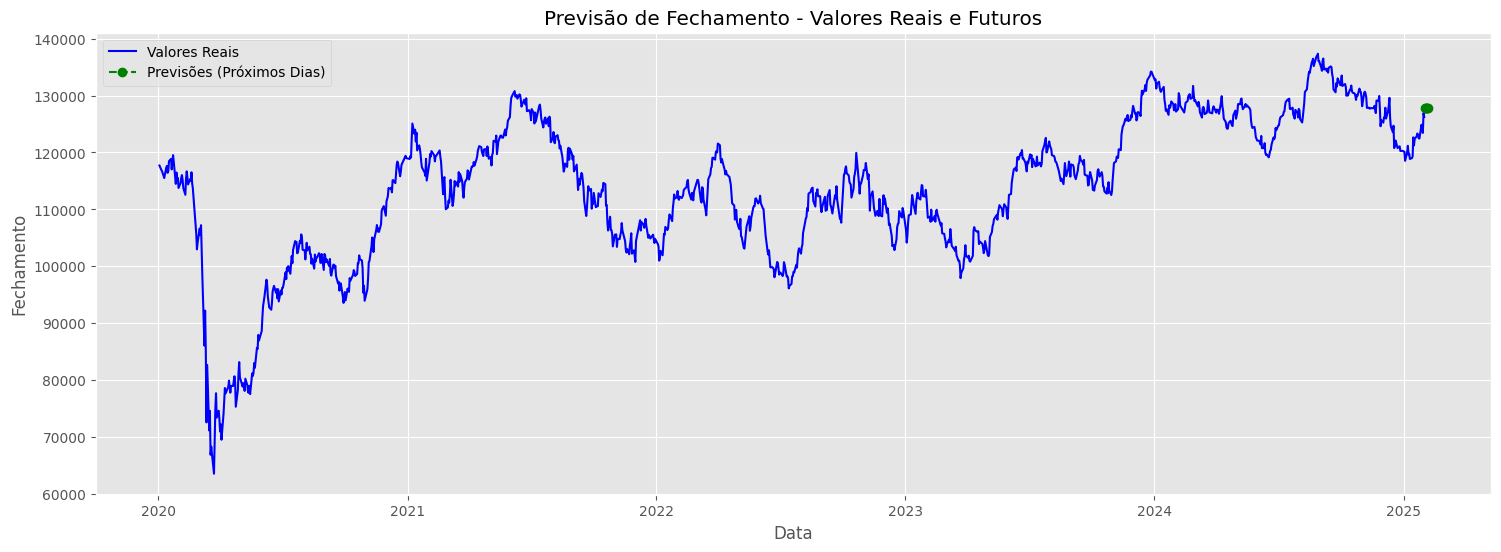

In [133]:
# Configuração do gráfico
plt.figure(figsize=(18, 6))

# Plot valores reais
plt.plot(df.index, df['Fechamento'], label='Valores Reais', color='blue')

# Adicione previsões para os próximos dias
plt.plot(future_dates, future_predictions, label='Previsões (Próximos Dias)', color='green', linestyle='--', marker='o')

# Configurações do gráfico
plt.title('Previsão de Fechamento - Valores Reais e Futuros')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()
plt.grid(True)

# Exiba o gráfico
plt.show()

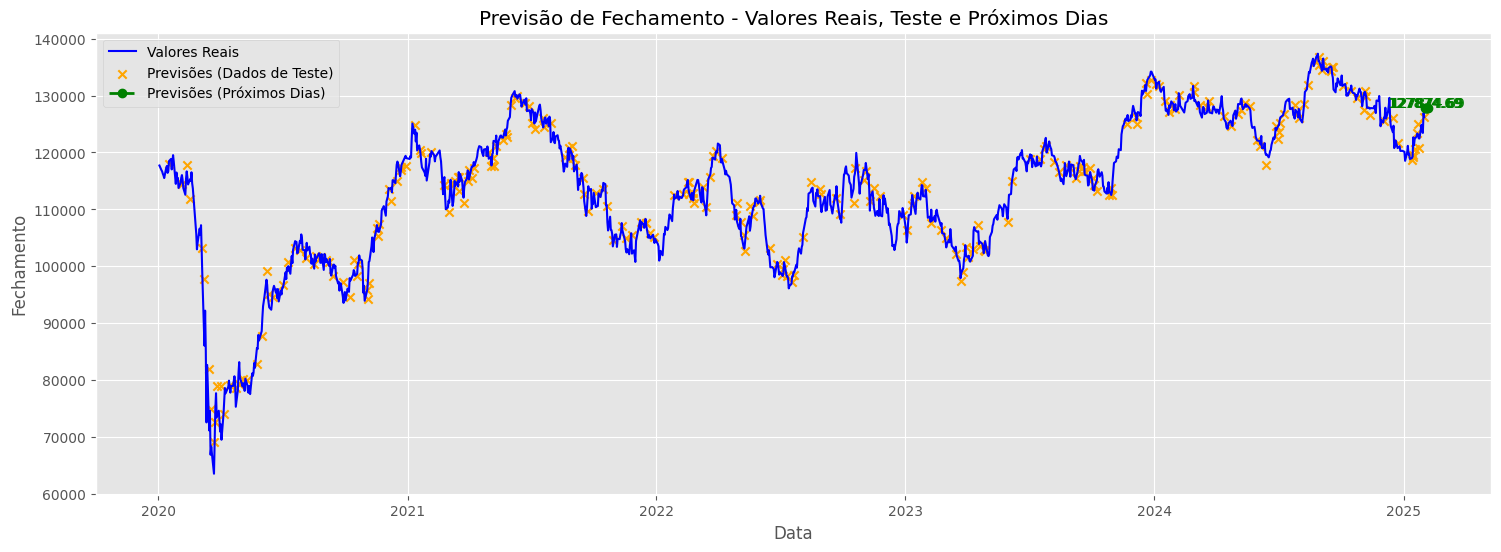

In [134]:

# Configuração do gráfico
plt.figure(figsize=(18, 6))

# Plotar os valores reais
plt.plot(df.index, df['Fechamento'], label='Valores Reais', color='blue')

# Plotar as previsões do conjunto de teste
plt.scatter(y_test.index, rf_predictions, label='Previsões (Dados de Teste)', color='orange', marker='x')

# Plotar as previsões futuras
plt.plot(future_dates, future_predictions, label='Previsões (Próximos Dias)', color='green', linestyle='--', marker='o', linewidth=2)

# Adicionar rótulos acima das bolinhas de previsão futura
for date, prediction in zip(future_dates, future_predictions):
    plt.text(date, prediction + 2,  # desloca +2 para cima no eixo Y
             f'{prediction:.2f}',  # formatação com 2 casas decimais
             color='green', fontsize=10, ha='center')

# Configuração do gráfico
plt.title('Previsão de Fechamento - Valores Reais, Teste e Próximos Dias')
plt.xlabel('Data')
plt.ylabel('Fechamento')
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()


In [135]:
# Adicionado mais lags e recursos derivados
df['Lag1'] = df['Fechamento'].shift(1)
df['Lag2'] = df['Fechamento'].shift(2)
df['Lag3'] = df['Fechamento'].shift(3)
df['Lag4'] = df['Fechamento'].shift(4)
df['Lag5'] = df['Fechamento'].shift(5)
df['Daily_Return'] = df['Fechamento'].pct_change()
df.dropna(inplace=True)

# Features para treino
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Daily_Return']]
y = df['Fechamento']

# Re-treino do modelo
rf.fit(X, y)

RandomForestRegressor(random_state=42)

In [136]:
df['Lag3'] = df['Fechamento'].shift(3)# Simulação com variabilidade baseada em histórico
future_predictions_adjusted = []
print("Previsões ajustadas:")
for pred in future_predictions:
    variation = np.random.uniform(-0.5, 0.5)  # Adiciona variação de até +/- 0.5
    adjusted_pred = pred + variation  # Adapta o valor com variação simulada
    future_predictions_adjusted.append(adjusted_pred)

for date, prediction in zip(future_dates, future_predictions_adjusted):
    print(f"{date.date()}: {prediction:.2f}")

Previsões ajustadas:
2025-02-01: 127875.04
2025-02-02: 127874.85
2025-02-03: 127874.63
2025-02-04: 127875.13
2025-02-05: 127875.00


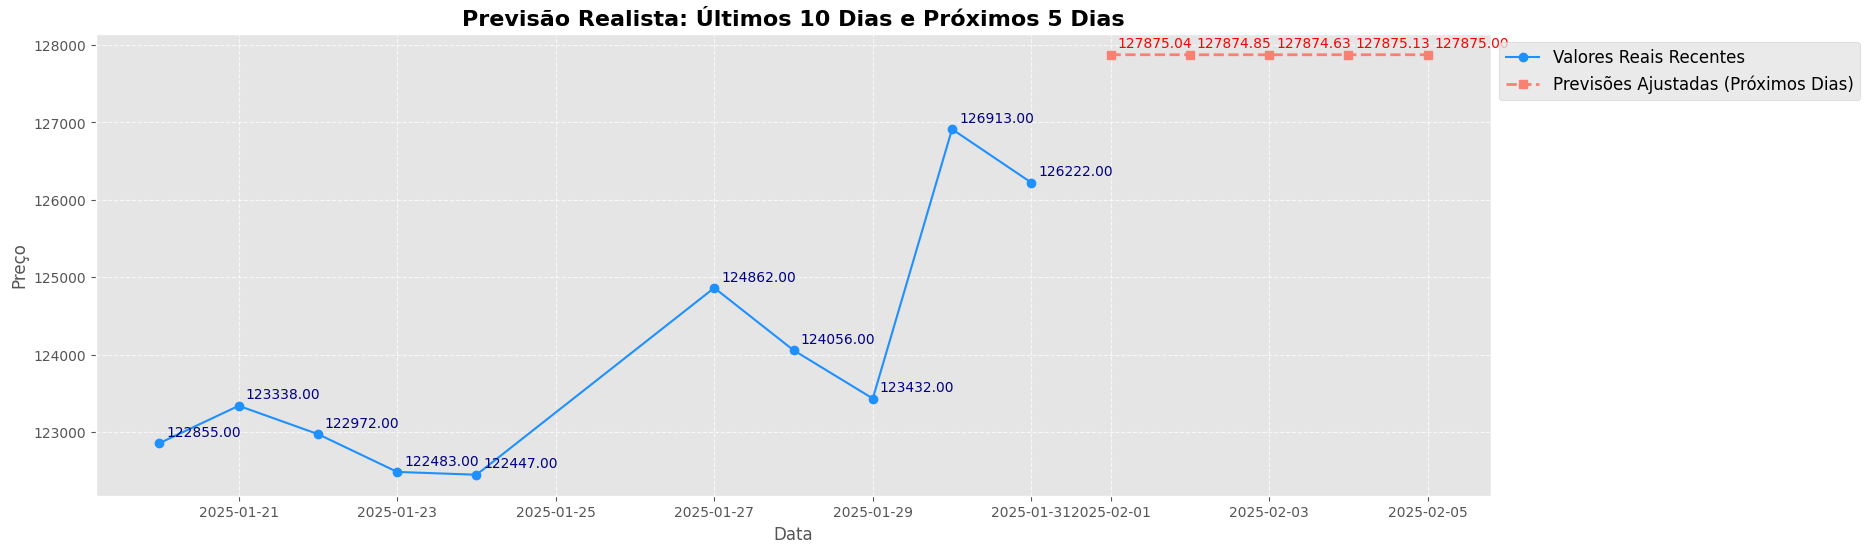

In [137]:
plt.style.use('ggplot')

plt.figure(figsize=(18, 6))
plt.plot(df.index[-10:], df['Fechamento'][-10:], label='Valores Reais Recentes', color='dodgerblue', marker='o')
plt.plot(future_features.index, future_predictions_adjusted,
         label='Previsões Ajustadas (Próximos Dias)', color='salmon', linestyle='--', marker='s', linewidth=2)

# Adicionar rótulos aos valores reais
for date, value in zip(df.index[-10:], df['Fechamento'][-10:]):
    plt.annotate(f'{value:.2f}', xy=(date, value), xytext=(5, 5),
                 textcoords='offset points', fontsize=10, color='navy')

# Adicionar rótulos às previsões futuras
for date, prediction in zip(future_features.index, future_predictions_adjusted):
    plt.annotate(f'{prediction:.2f}', xy=(date, prediction), xytext=(5, 5),
                 textcoords='offset points', fontsize=10, color='red')

plt.title('Previsão Realista: Últimos 10 Dias e Próximos 5 Dias', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()

In [103]:
# Calcule métricas mais detalhadas
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

# Exiba as métricas calculadas
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest MSE: {rf_mse:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest R²: {rf_r2:.2f}")

Random Forest MAE: 1460.04
Random Forest MSE: 4378158.20
Random Forest RMSE: 2092.40
Random Forest R²: 0.98
